In [1]:
# 导入库
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
# 导入包含特征、赔付概率和赔付金额的数据集（x, y_prob, y_amount）
data = pd.read_csv('E:/my_data1.csv')  # 导入数据
# 创建LabelEncoder对象
label_encoder = LabelEncoder()
# 对指定列进行标签编码
data['veh_body_encoded'] = label_encoder.fit_transform(data['veh_body'])
data['area_encoded'] = label_encoder.fit_transform(data['area'])
data['amount_per_exposure'] = data['claimcst0']/data['exposure']
# 输入特征和真实y值
x = data[['veh_value', 'veh_age', 'agecat', 'gender', 'veh_body_encoded', 'area_encoded']].values
y_prob = data[['clm']].values
y_amount = data[['amount_per_exposure']].values
# 划分训练集和测试集
x_train, x_test, y_prob_train, y_prob_test, y_amount_train, y_amount_test = train_test_split(x, y_prob, y_amount,
                                                                                             test_size=0.2,
                                                                                             random_state=42)

In [3]:
# 定义函数 t(p)
def t_function(p, T):
    return (T - p) / (1 - p)
# 定义T
T = 0.95

In [4]:
# 将类别标签反转
y_prob_train_inverted = 1 - y_prob_train
# 使用逻辑回归模型
logistic_model = LogisticRegression()
# 训练逻辑回归模型
logistic_model.fit(x_train, y_prob_train_inverted.squeeze())
# 获取训练集逻辑回归模型的预测概率
predictions_A = torch.Tensor(logistic_model.predict_proba(x_train)[:, 1])
# 计算训练集的 tau
t_p = t_function(predictions_A, T)
# 计算测试集的tau
predictions_A_test = torch.Tensor(logistic_model.predict_proba(x_test)[:, 1])
t_p_test = t_function(predictions_A_test, T)
# 打印predictions_A、t_p、predictions_A_test、t_p_test
print("predictions_A:", predictions_A)
print("t_p:",t_p)
print("predictions_A_test:", predictions_A_test)
print("t_p_test:", t_p_test)

predictions_A: tensor([0.9072, 0.9336, 0.9208,  ..., 0.9355, 0.9356, 0.9198])
t_p: tensor([0.4614, 0.2474, 0.3687,  ..., 0.2247, 0.2235, 0.3769])
predictions_A_test: tensor([0.9253, 0.9397, 0.9353,  ..., 0.9366, 0.9481, 0.9202])
t_p_test: tensor([0.3306, 0.1710, 0.2273,  ..., 0.2116, 0.0375, 0.3736])


In [5]:
# 转换数据为PyTorch张量
x_train = torch.Tensor(x_train)
x_test = torch.Tensor(x_test)
y_prob_train = torch.Tensor(y_prob_train)
y_amount_train = torch.Tensor(y_amount_train)
y_prob_test = torch.Tensor(y_prob_test)
y_amount_test = torch.Tensor(y_amount_test)

In [6]:
# 定义NetworkB loss
class NetworkBLoss(nn.Module):
    def __init__(self, epsilon, t_p):
        super(NetworkBLoss, self).__init__()
        self.epsilon = epsilon
        self.t_p = t_p

    def h_function(self, u):
        return torch.where(torch.abs(u) > self.epsilon, torch.abs(u) - 0.5 * self.epsilon, (u ** 2) / (2 * self.epsilon))

    def rho_function(self, u):
        self.t_p = self.t_p.unsqueeze(2)
        if torch.any(self.t_p) <= 0:
            return torch.zeros_like(u)
        else:
            return torch.where(u >= 0, self.t_p * self.h_function(u), (1 - self.t_p) * self.h_function(u) + 1e-6)


    def forward(self, y, Q_y):
        residuals = y - Q_y
        loss = torch.mean(self.rho_function(residuals))
        return loss

In [7]:
# 定义神经网络结构

class NetworkB(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NetworkB, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
# 定义参数、创建网络实例
input_size = 6
hidden_size1 = 64
hidden_size2 = 128
output_size = 1
epsilon = 2 ** (-9)
networkB = NetworkB(input_size, hidden_size1, hidden_size2, output_size)

# 定义网络A和网络B的优化器，以优化参数
optimizerB = optim.Adam(networkB.parameters(), lr=0.005)

# 存储训练过程中的损失值和测试结果
loss_B_values = []
test_error_values = []
test_mse_values = []

In [9]:
# 训练循环
epochs = 900
for epoch in range(epochs):
    # 仅选择赔付金额不为零的数据传递给 NetworkB
    non_zero_claim_indices = y_amount_train.nonzero().squeeze(1)
    # 创建网络B损失函数实例
    criterion_B = NetworkBLoss(epsilon, t_p[non_zero_claim_indices])

    if len(non_zero_claim_indices) > 0:
        x_train_B = x_train[non_zero_claim_indices]
        y_amount_train_B = y_amount_train[non_zero_claim_indices]

        # 前向传播 NetworkB
        predictions_B = networkB(x_train_B)
        # 计算 NetworkB 的损失函数，更新 NetworkB 的参数
        loss_B = criterion_B(y_amount_train_B, predictions_B)
        optimizerB.zero_grad()
        loss_B.backward(retain_graph=True)
        optimizerB.step()
        loss_B_values.append(loss_B.item())
        # 切换到评估模式在每个 epoch 结束后进行测试
        networkB.eval()

        with torch.no_grad():  # 禁用梯度计算，因为在测试阶段我们不需要计算梯度
            # 仅选择赔付金额不为零的数据传递给 NetworkB
            non_zero_test_claim_indices = y_amount_test.nonzero().squeeze(1)
            if len(non_zero_test_claim_indices) > 0:
                x_test_B = x_test[non_zero_test_claim_indices]
                y_amount_test_B = y_amount_test[non_zero_test_claim_indices]

                # 测试集的向前传播
                predictions_B_test = networkB(x_test_B)
                criterion_B = NetworkBLoss(epsilon, t_p_test[non_zero_test_claim_indices])
                test_error = criterion_B(y_amount_test_B, predictions_B_test).item()
                test_error_values.append(test_error)
                # 计算测试集MSE
                test_mse = nn.MSELoss()(predictions_B_test.reshape(-1,1), y_amount_test_B.reshape(-1, 1))
                test_mse_values.append(test_mse.item())
                
        # 恢复到训练模式
        networkB.train()


In [10]:
# 输出最终的损失值和测试结果
print("Final Loss B:", loss_B_values[-1])
print("Final Test Error:", test_error_values[-1])
print("Final Test MSE",test_mse_values[-1])
print("Final Test RMSE:",np.sqrt(test_mse_values[-1]))

Final Loss B: 1410.9366455078125
Final Test Error: 1851.806396484375
Final Test MSE 3243402752.0
Final Test RMSE: 56950.88016879107


In [11]:
# 找到最小的MSE值及其对应的轮次
min_mse = min(test_mse_values)
min_mse_epoch = test_mse_values.index(min_mse) + 1  # 轮次从1开始
print("Min Test RMSE:",np.sqrt(min_mse))
print(f"最小的MSE值: {min_mse}，对应的轮次: {min_mse_epoch}")

Min Test RMSE: 56947.52897185268
最小的MSE值: 3243021056.0，对应的轮次: 858


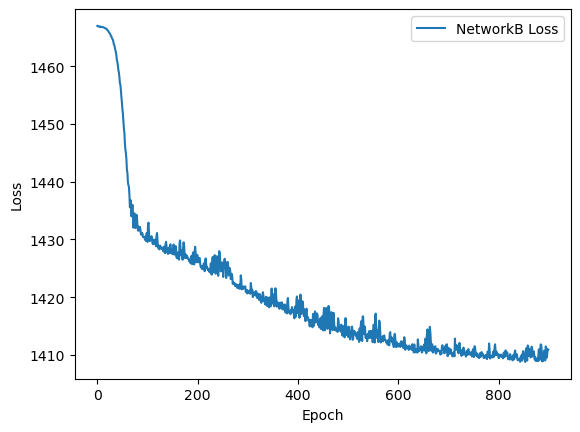

In [12]:
# 绘制网络B损失曲线
plt.plot(loss_B_values, label='NetworkB Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

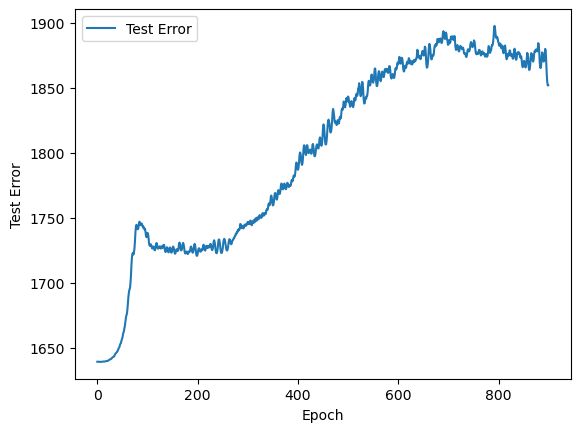

In [13]:
# 绘制测试集误差曲线
plt.plot(test_error_values, label='Test Error')
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.legend()
plt.show()

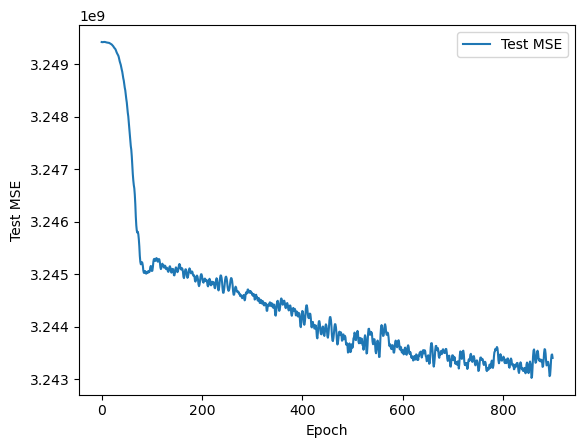

In [14]:
# 绘制测试集MSE曲线
plt.plot(test_mse_values, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Test MSE')
plt.legend()
plt.show()